In [18]:
import dask.dataframe as dd
import os
import numpy as np
from sklearn.metrics import (accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve, ConfusionMatrixDisplay, classification_report, auc, roc_curve, precision_recall_fscore_support, f1_score)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# Paths

In [19]:
processed_dir = os.path.join( "..", "data", "processed")

final_dataset_path = os.path.join(processed_dir, 'FEData_For_Modelling.parquet')

minority_users_dt_pq = os.path.join(processed_dir, 'minority_users_dt.parquet')
minority_users_smote_dt_pq = os.path.join(processed_dir, 'minority_users_dt_smote.parquet')

minority_users_svm_pq = os.path.join(processed_dir, 'minority_users_svm.parquet')
minority_users_smote_svm_pq = os.path.join(processed_dir, 'minority_users_svm_smote.parquet')

minority_users_nn_pq = os.path.join(processed_dir, 'minority_users_nn.parquet')
minority_users_smote_nn_pq = os.path.join(processed_dir, 'minority_users_nn_smote.parquet')


# Figures
figures_dir = os.path.join( "..", "materials", "reports", "figures")

bar_graph_minority_path = os.path.join(figures_dir, 'bar_graph_minority.png')
bar_graph_minority_smote_path = os.path.join(figures_dir, 'bar_graph_minority_smote.png')

combined_metrics_path = os.path.join(figures_dir, 'combined_metrics.png')

roc_curves_smote_path = os.path.join(figures_dir, 'roc_curves_smote.png')
roc_curves_path = os.path.join(figures_dir, 'roc_curves.png')

Import Dataset

In [20]:
# Read the multi-part Parquet dataset
dt_data = dd.read_parquet(minority_users_dt_pq)
smote_dt_data = dd.read_parquet(minority_users_smote_dt_pq)

svm_data = dd.read_parquet(minority_users_svm_pq)
smote_svm_data = dd.read_parquet(minority_users_smote_svm_pq)

nn_data = dd.read_parquet(minority_users_nn_pq)
smote_nn_data = dd.read_parquet(minority_users_smote_nn_pq)

svm_data.head(4000)

,User,Actual,Prediction,Confidence of Prediction
23,ACD1174,False,False,0.346870
29,ACH1840,False,False,0.646525
30,ACJ1797,False,False,0.509427
32,ACR1045,False,False,0.319632
44,AEF1032,False,False,0.474186
...,...,...,...,...
1966,YVJ0986,False,False,0.319705
1978,ZDH1266,False,False,0.537505
1981,ZHB1104,False,False,0.509979
1987,ZJT1601,False,False,0.645781


Checking if all Test users are there and are the same

In [21]:
a = set(svm_data['User'].values.compute())
b = set(nn_data['User'].values.compute())
c = set(dt_data['user'].values.compute())
d = set(smote_svm_data['User'].values.compute())
e = set(smote_nn_data['User'].values.compute())
f = set(smote_dt_data['user'].values.compute())
if a == b == c == d == e == f:
    print("All variables are equal.")

All variables are equal.


c:\Users\hydro\AppData\Local\Programs\Python\Python312\Lib\site-packages\dask\dataframe\core.py:3930: UserWarning: Dask currently has limited support for converting pandas extension dtypes to arrays. Converting string to object dtype.
  warnings.warn(
c:\Users\hydro\AppData\Local\Programs\Python\Python312\Lib\site-packages\dask\dataframe\core.py:3930: UserWarning: Dask currently has limited support for converting pandas extension dtypes to arrays. Converting string to object dtype.
  warnings.warn(
c:\Users\hydro\AppData\Local\Programs\Python\Python312\Lib\site-packages\dask\dataframe\core.py:3930: UserWarning: Dask currently has limited support for converting pandas extension dtypes to arrays. Converting string to object dtype.
  warnings.warn(
c:\Users\hydro\AppData\Local\Programs\Python\Python312\Lib\site-packages\dask\dataframe\core.py:3930: UserWarning: Dask currently has limited support for converting pandas extension dtypes to arrays. Converting string to object dtype.
  warning

Sorting Alphabetically

In [22]:
# Sort dt_data by 'User' column
sorted_dt_data = dt_data.sort_values(by='user')

# Sort smote_dt_data by 'User' column
sorted_smote_dt_data = smote_dt_data.sort_values(by='user')

# Sort svm_data by 'User' column
sorted_svm_data = svm_data.sort_values(by='User')

# Sort smote_svm_data by 'User' column
sorted_smote_svm_data = smote_svm_data.sort_values(by='User')

# Sort nn_data by 'User' column
sorted_nn_data = nn_data.sort_values(by='User')

# Sort smote_nn_data by 'User' column
sorted_smote_nn_data = smote_nn_data.sort_values(by='User')

sorted_dt_data.head()

,user,Actual,Prediction,Decision Path,GINI Confidence of Prediction,normal_prob,malicious_prob
209,ACD1174,False,False,"[0, 1, 2, 3]",0.171213,0.99616,0.00384
29,ACH1840,False,False,"[0, 1, 2, 3]",0.171213,0.99616,0.00384
309,ACJ1797,False,False,"[0, 1, 2, 3]",0.171213,0.99616,0.00384
262,ACR1045,False,False,"[0, 1, 2, 3]",0.171213,0.99616,0.00384
320,AEF1032,False,False,"[0, 1, 2, 3]",0.171213,0.99616,0.00384


In [6]:
def ensemble_predictions(dt,svm,nn):
    conf_dt = np.maximum(dt['malicious_prob'].values.compute(),dt['normal_prob'].values.compute()) 
    conf_svm = svm['Confidence of Prediction'].values.compute()
    conf_nn = nn['Confidence of Prediction'].values.compute()
    total_conf = conf_dt + conf_svm + conf_nn
    weight_dt = conf_dt/total_conf
    weight_svm = conf_svm/total_conf
    weight_nn = conf_nn/total_conf
    y_pred = weight_dt*dt['Prediction'].values.compute() + weight_svm*svm['Prediction'].values.compute() + weight_nn*nn['Prediction'].values.compute()
    return  y_pred
    #dt[malicious_prob]*

In [9]:
y_pred_prob = ensemble_predictions(sorted_smote_dt_data,sorted_svm_data,sorted_nn_data)
#All the y test are the same so just taking from the first dataset
y_test = smote_dt_data['Actual'].values.compute()

Threshold tuning

In [10]:
def calculate_tp_fp_fn(y_true, y_pred_prob, threshold):
    """
    Calculate True Positives (TP), False Positives (FP), and False Negatives (FN) 
    based on the given true labels (y_true) and predicted labels (y_pred) with a given threshold.
    
    Args:
    - y_true: True labels
    - y_pred: Predicted labels (probabilities or scores)
    - threshold: Threshold for classification
    
    Returns:
    - TP: Number of True Positives
    - FP: Number of False Positives
    - FN: Number of False Negatives
    """
    y_pred_binary = (y_pred_prob > threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred_binary)
    TN, FP, FN, TP = cm.ravel()
    
    return TP, FP, FN

In [11]:
def threshold_tuning(y_test,y_pred_prob,tp_weight,fp_weight,fn_weight, threshold = 0.5):
    best_t_score = float('-inf')
    best_threshold = threshold
    while threshold >= 0: 
        Tp, Fp , Fn = calculate_tp_fp_fn(y_test, y_pred_prob, threshold)
        t_score = Tp*tp_weight - Fp*fp_weight - Fn*fn_weight
        threshold -= 0.01
        if t_score > best_t_score:
            best_t_score = t_score
            best_threshold = threshold
    return best_threshold

0.4299999999999995
Accuracy = 99.25%
Precision = 1.0
Recall = 0.25
f-1 score = 0.4

Classification Report:
               precision    recall  f1-score   support

       False       0.99      1.00      1.00       396
        True       1.00      0.25      0.40         4

    accuracy                           0.99       400
   macro avg       1.00      0.62      0.70       400
weighted avg       0.99      0.99      0.99       400



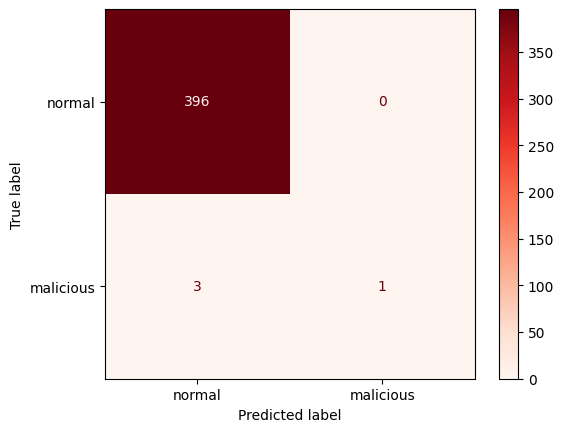

In [26]:
threshold = threshold_tuning(y_test,y_pred_prob,tp_weight= 2, fp_weight= 1,fn_weight=0.5,threshold = 1)
print(threshold)
y_pred = (y_pred_prob > threshold).astype(int)
set(list(y_pred.flatten()))


accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['normal', 'malicious'])

print("Accuracy = {:.2f}%".format(accuracy_score(y_test, y_pred)*100))
print("Precision = {}".format(precision_score(y_test, y_pred)))
print("Recall = {}".format(recall_score(y_test, y_pred)))
print("f-1 score = {}".format(f1_score(y_test, y_pred)))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
disp.plot(cmap=plt.cm.Reds)
plt.show()

AUC score: 0.625


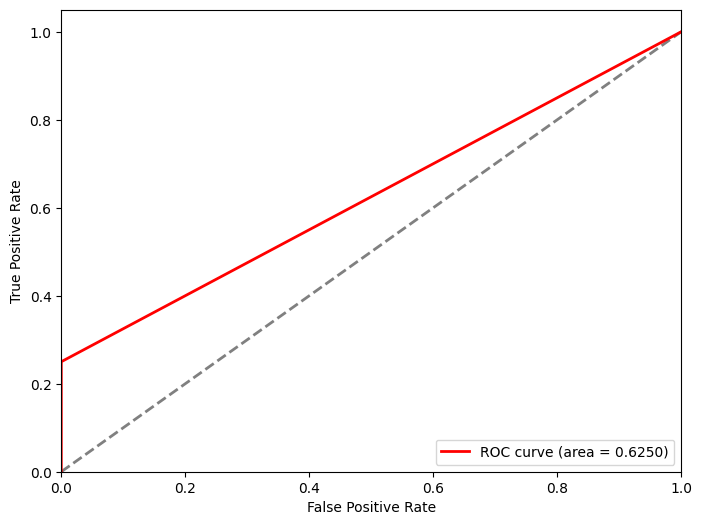

In [27]:
# ROC - AUC
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    plt.figure(figsize=(8, 6))
    #y_prob = best_dt.predict_proba(X_test_scaled)[::,1]
    dt_fpr, dt_tpr, thresholds = roc_curve(true_y, y_prob)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    roc_auc = auc(dt_fpr, dt_tpr)
    plt.plot(dt_fpr, dt_tpr, color='red', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.legend(loc="lower right")

    # plt.legend()

plot_roc_curve(y_test, y_pred)
print(f'AUC score: {roc_auc_score(y_test, y_pred)}')